In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install hanja

In [ ]:
import hanja
from hanja import hangul

In [ ]:
import gc
import pandas as pd
import numpy as np
import re
import tensorflow
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import accuracy_score
gc.collect()

30

In [ ]:
cd /content/gdrive/My Drive/dacon/NH

/content/gdrive/My Drive/dacon/NH


In [ ]:
train = pd.read_csv('news_train.csv')
test = pd.read_csv("news_test.csv")
submission = pd.read_csv("sample_submission.csv")

In [ ]:
train.head()

,n_id,date,title,content,ord,info
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0


In [ ]:
test.head()

,n_id,date,title,content,ord,id
0,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1
1,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2
2,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,3,NEWS00237_3
3,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,4,NEWS00237_4
4,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",5,NEWS00237_5


In [ ]:
submission.head()

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0


### Preprocessing


In [ ]:
train['length_text'] = train.content.apply(lambda x : len(x))
test['length_text'] = test.content.apply(lambda x : len(x))

In [ ]:
train.sample(10)

,n_id,date,title,content,ord,info,length_text
64992,NEWS00705,20200519,"백악관 백신개발 총책, “모더나 스톡옵션 보유, 이해상충” 지적에 처분",정치테마 매집+거래량+핵심인맥 당장 줄상한가 가도 책임안집니다,84,1,34
106154,NEWS05798,20200331,"‘꽃 보다 코로나’…강북구, 우이천변 벚꽃길 통제",통제구역은 신창교에서 쌍한교에 이르는 벚꽃길 조성구간과 번2동 주민센터 주변 지점부...,10,0,82
23146,NEWS02300,20200315,정의당 '대리게임' 논란 류호정 재신임 … '음주운전' 신장식은 자진 사퇴,1번인 류호정 당 IT산업노동특별위원장과 6번인 신장식 전 사무총장은 비례대표 후보...,6,0,126
106040,NEWS03010,20200508,"“용산, 진짜 로또가 나타났다”…부풀어 오른 청약 기대감",저평가+실적+재료 받쳐주는 바이오 대장株. 2020년 한 종목으로 끝,84,1,38
32158,NEWS05895,20200513,"부산도 이태원 클럽발 '2차 감염' 나왔다…""1살 조카 확진""",13일 부산시 코로나19 현안브리핑에 따르면 전날까지 부산 이태원 클럽 방문 확진자...,5,0,60
84263,NEWS07042,20200629,"항바이러스제·AI융복합기술, 기술사업화 날개 단다","인공지능산업 집중 육성전략과 발맞춰 AI 기반 정밀의료, 스마트 공장, 관제시스템,...",11,0,119
91428,NEWS07176,20200410,인순이 ‘범국민 코로나 극복 캠페인송’ 재능기부,업계 최저금리 2.29%. 100%한종목 투자가능+신용/ 미수 대환가능,24,1,39
106349,NEWS00650,20200224,"""서울은 사실상 거래허가제""…3억원 이상 주택 매입시 자금출처 소명",10%수익을 40%로 만들어 준다고.. 영웅스탁론이라면 가능~.효과적인 레버리지를 ...,121,1,61
61149,NEWS07851,20200420,[인터뷰]종로 장수카페의 변신…커피 넘어 ‘공간’을 팔다,지난달 23일 광화문점 문을 연 것이다,181,0,21
40240,NEWS03397,20200217,호주정부도 日 크루즈선 탑승 자국민 200여명 대피 계획 밝혀,"모리슨 총리는 ""탑승자와 가족들이 이런 방침에 실망감을 느낄 것이라는 점을 충분히 ...",8,0,106


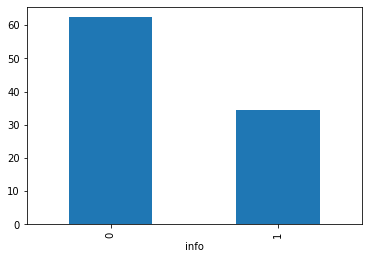

In [ ]:
train.groupby('info').length_text.mean().plot(kind = 'bar')
plt.show()

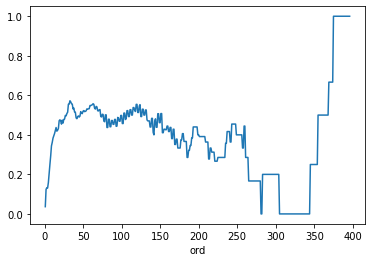

In [ ]:
train.groupby('ord')['info'].mean().plot()

In [ ]:
train['text'] = train.content
test['text'] = test.content

In [ ]:
train.text = train.text.apply(lambda x : hanja.translate(x, 'substitution'))
test.text = test.text.apply(lambda x : hanja.translate(x, 'substitution'))

In [ ]:
train_text = list(train['text'])

train_clear_text = []

for i in tqdm(range(len(train_text))):
  train_clear_text.append(str(train_text[i]).replace('\\n', ''))
train['clear_text'] = train_clear_text
train.head()

100%|██████████| 118745/118745 [00:00<00:00, 1460102.46it/s]


,n_id,date,title,content,ord,info,text,clear_text
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개","""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개"
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시","하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시"
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0,전국적인 소비 붐 조성에 기여할 예정,전국적인 소비 붐 조성에 기여할 예정


In [ ]:
train_clear_text = list(train['clear_text'])

train_clear_text2 = []

for text in train_clear_text:
  temp = re.sub('[-=+,#:;//●<>▲\?:^$%&.↑☆!★()Ⅰ@*\"※~>`\'…》]', ' ', text)
  train_clear_text2.append(temp)
train['clear_text'] = train_clear_text2
train.sample(10)

,n_id,date,title,content,ord,info,text,clear_text
77722,NEWS03405,20200102,오를만큼 올랐나…코스피 ETF에 대차거래 몰려,바이오는 배신하지 않는다. 급등임박. 2020년까지 접수한다 BEST3 공개.,106,1,바이오는 배신하지 않는다. 급등임박. 2020년까지 접수한다 BEST3 공개.,바이오는 배신하지 않는다 급등임박 2020년까지 접수한다 BEST3 공개
5133,NEWS03368,20200106,"‘보니하니’ 최영수, 아프리카 방송 재개…“요즘 잠 안와”",이어 정말 사람 무서워서 방송하겠냐 싶다,18,0,이어 정말 사람 무서워서 방송하겠냐 싶다,이어 정말 사람 무서워서 방송하겠냐 싶다
111606,NEWS01464,20200521,[분양 포커스]6호선·경의중앙선…‘신내역 시티프라디움’ 관심 집중,아파트 견본주택은 서울시 동대문구 용두동 23-1에 위치한다,126,0,아파트 견본주택은 서울시 동대문구 용두동 23-1에 위치한다,아파트 견본주택은 서울시 동대문구 용두동 23 1에 위치한다
42718,NEWS02295,20200617,"[일문일답] ""김포 집값, 우려할 수준 아니야…가격 오르면 즉시 규제""",전세금 대출 제한을 통해서 갭투자를 막으려고 하지만 실수요자가 주택을 마련하는 것에...,27,0,전세금 대출 제한을 통해서 갭투자를 막으려고 하지만 실수요자가 주택을 마련하는 것에...,전세금 대출 제한을 통해서 갭투자를 막으려고 하지만 실수요자가 주택을 마련하는 것에...
93468,NEWS00474,20200420,메디톡스 “안전성 문제없다”…‘제조·판매 중지’에 행정소송 맞불,아직도 추천주를 돈내고 받으세요.,20,1,아직도 추천주를 돈내고 받으세요.,아직도 추천주를 돈내고 받으세요
102726,NEWS02124,20200414,"대성홀딩스, 52주 신고가",저평가+실적+재료 받쳐주는 바이오 대장株. 2020년 한 종목으로 끝,26,1,저평가+실적+재료 받쳐주는 바이오 대장株. 2020년 한 종목으로 끝,저평가 실적 재료 받쳐주는 바이오 대장株 2020년 한 종목으로 끝
111001,NEWS05297,20200227,"'코로나19 업무' 전주시 공무원, 집에서 숨진 채 발견",[헤럴드경제(전주)=박대성 기자] 신종 코로나바이러스 감염증(코로나19) 지원 업무...,37,0,[헤럴드경제(전주)=박대성 기자] 신종 코로나바이러스 감염증(코로나19) 지원 업무...,[헤럴드경제 전주 박대성 기자] 신종 코로나바이러스 감염증 코로나19 지원 업무...
103226,NEWS01822,20200109,"밖은 -5도, 고수동굴 안은 +15도, 동굴여행 어때요?",충북의 동굴들은 단양에 집중돼 있다,18,0,충북의 동굴들은 단양에 집중돼 있다,충북의 동굴들은 단양에 집중돼 있다
113954,NEWS04585,20200227,"교사노조연맹, 학교 휴업으로 ‘점심 결손학생’ 32만명…모금운동 전개",2020년 한국 TV 2대중 1대 인터넷 연결된다,30,1,2020년 한국 TV 2대중 1대 인터넷 연결된다,2020년 한국 TV 2대중 1대 인터넷 연결된다
47515,NEWS05178,20200330,"이윤지·정한울 부부, 둘째 출산으로 '동상이몽2' 잠시 하차",과연 이들이 몰래 준비한 파티를 본 이윤지의 반응은 어떨지 궁금증을 높인다,7,0,과연 이들이 몰래 준비한 파티를 본 이윤지의 반응은 어떨지 궁금증을 높인다,과연 이들이 몰래 준비한 파티를 본 이윤지의 반응은 어떨지 궁금증을 높인다


In [ ]:
test_text = list(test['text'])

test_clear_text = []

for i in tqdm(range(len(test_text))):
  test_clear_text.append(str(test_text[i]).replace('\\n', ''))
test['clear_text'] = test_clear_text
test.head()

100%|██████████| 142565/142565 [00:00<00:00, 1345592.11it/s]


,n_id,date,title,content,ord,id,text,clear_text
0,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1,마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가'
1,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2,[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...
2,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,3,NEWS00237_3,최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...
3,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,4,NEWS00237_4,TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...
4,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",5,NEWS00237_5,"코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에..."


In [ ]:
test_clear_text = list(test['clear_text'])

test_clear_text2 = []

for text in test_clear_text:
  temp = re.sub('[-=+,#:;//●<>▲\?:^$%&.↑☆!★()Ⅰ@*\"※~>`\'…》]', ' ', text)
  test_clear_text2.append(temp)
test['clear_text'] = test_clear_text2
test.sample(10)

,n_id,date,title,content,ord,id,text,clear_text
90115,NEWS08231,20200107,"[속보] 문재인 대통령 ""3대 신산업 등 고부가가치 수출 늘리고 신남방ㆍ신북방 새 ...",(무단 전재 및 재배포 금지),6,NEWS08231_6,(무단 전재 및 재배포 금지),무단 전재 및 재배포 금지
69139,NEWS03192,20200224,"중국 우한, 비거주자 봉쇄조치 완화…지방정부 대응단계 하향조정(종합)","후베이성을 제외한 지역의 신규 확진자 수도 21일 31명, 22일에는 18명, 23...",22,NEWS03192_22,"후베이성을 제외한 지역의 신규 확진자 수도 21일 31명, 22일에는 18명, 23...",후베이성을 제외한 지역의 신규 확진자 수도 21일 31명 22일에는 18명 23...
73741,NEWS04785,20200327,"무주군, 소상공인 특별지원 10억원 투입",신종코로나 바이러스 1000% 갈 新 대장주 大공개,11,NEWS04785_11,신종코로나 바이러스 1000% 갈 新 대장주 大공개,신종코로나 바이러스 1000 갈 新 대장주 大공개
70817,NEWS08034,20200304,보험사들 '주가 부양' 나선다...배당 늘리고 자사주 매입,저금리 장기화와 손해율 악화 등으로 보험사들의 주가는 크게 하락한 상태다,2,NEWS08034_2,저금리 장기화와 손해율 악화 등으로 보험사들의 주가는 크게 하락한 상태다,저금리 장기화와 손해율 악화 등으로 보험사들의 주가는 크게 하락한 상태다
117774,NEWS01849,20200117,"5G 인프라 활성화…공유기, 단말장비株 미리 담아둬야",바이오는 배신하지 않는다. 급등임박. 2020년까지 접수한다 BEST3 공개.,102,NEWS01849_102,바이오는 배신하지 않는다. 급등임박. 2020년까지 접수한다 BEST3 공개.,바이오는 배신하지 않는다 급등임박 2020년까지 접수한다 BEST3 공개
89210,NEWS06800,20200426,"[테크리더십] KT, 대규모 망 인프라로 공익 제공에 앞장","Copyright이투데이, All rights reserved",23,NEWS06800_23,"Copyright이투데이, All rights reserved",Copyright이투데이 All rights reserved
110283,NEWS08619,20200224,"‘퍼즐오디션’, 3월 5일 파이널테스트 예고",정치테마 매집+거래량+핵심인맥 당장 줄상한가 가도 책임안집니다,23,NEWS08619_23,정치테마 매집+거래량+핵심인맥 당장 줄상한가 가도 책임안집니다,정치테마 매집 거래량 핵심인맥 당장 줄상한가 가도 책임안집니다
7252,NEWS09281,20200619,"'삼륭물산' 10% 이상 상승, 주가 상승세, 단기 이평선 역배열 구간","""100만원""만 있어도 지금 당장 ""이것""부터 사라.. .",4,NEWS09281_4,"""100만원""만 있어도 지금 당장 ""이것""부터 사라.. .",100만원 만 있어도 지금 당장 이것 부터 사라
71101,NEWS04029,20200227,"서울대 식대 인상 갈등, 법정 공방까지...""학교가 재정 지원해야""",앞서 생협은 재정적자를 이유로 3월 5일 이사회에 식대 인상안을 정식 상정하기로 했다,4,NEWS04029_4,앞서 생협은 재정적자를 이유로 3월 5일 이사회에 식대 인상안을 정식 상정하기로 했다,앞서 생협은 재정적자를 이유로 3월 5일 이사회에 식대 인상안을 정식 상정하기로 했다
28016,NEWS06246,20200226,대구MBC와 경기방송에 무슨일이?..지상파 방송 ‘흔들’,표철수 위원은 제가 재허가 심사위원장이었는데 당시에는 없던 상황이었다면서 3월 주총...,27,NEWS06246_27,표철수 위원은 제가 재허가 심사위원장이었는데 당시에는 없던 상황이었다면서 3월 주총...,표철수 위원은 제가 재허가 심사위원장이었는데 당시에는 없던 상황이었다면서 3월 주총...


In [ ]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.


In [ ]:
cd Mecab-ko-for-Google-Colab/

/content/gdrive/My Drive/dacon/NH/Mecab-ko-for-Google-Colab


In [ ]:
!bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 172kB/s 
     |████████████████████████████████| 92kB 13.4MB/s 
     |████████████████████████████████| 460kB 47.7MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2020-11-25 00:45:22--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 18.205.93.0, 18.205.93.2, 18.205.93.1, ...
Connecting to bitbucket.org (bitbucket.org)|18.205.93.0|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

In [ ]:
train_token = []

text = list(train['clear_text'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = mecab.pos(text[i]) # 토큰화
  #temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
  temp_X = [word for word in temp_X if len(word) > 1]
  train_token.append(temp_X)

100%|██████████| 118745/118745 [00:13<00:00, 8650.27it/s]


In [ ]:
X_train = []
for t in train_token :
  token_list = []
  for c in np.arange(len(t)) :
    if ('V' in t[c][1]) or ('N' in t[c][1]) :
      token = t[c][0]+t[c][1]
      token_list.append(token)
    else:
      pass
  X_train.append(token_list)

In [ ]:
test_token = []

text = list(test['clear_text'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = mecab.pos(text[i]) # 토큰화
  #temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
  temp_X = [word for word in temp_X if len(word) > 1]
  test_token.append(temp_X)

100%|██████████| 142565/142565 [00:15<00:00, 9247.34it/s]


In [ ]:
X_test = []
for t in test_token :
  token_list = []
  for c in np.arange(len(t)) :
    if ('V' in t[c][1]) or ('N' in t[c][1]) :
      token = t[c][0]+t[c][1]
      token_list.append(token)
    else:
      pass
  X_test.append(token_list)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 8
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 38598
등장 빈도가 7번 이하인 희귀 단어의 수: 25753
단어 집합에서 희귀 단어의 비율: 66.72107363075807
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.396252890832053


In [ ]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 12846


In [ ]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
token_X_train = tokenizer.texts_to_sequences(X_train)
token_X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
drop_train = [index for index, sentence in enumerate(token_X_train) if len(sentence) < 1]

In [ ]:
del_X_train = np.delete(token_X_train, drop_train, axis=0)
del_y_train = train.query('index not in @drop_train')['info']
print(len(del_X_train))
print(len(del_y_train))

118561
118561


train data의 최대 길이 : 1131
train data의 평균 길이 : 15.445778966101837


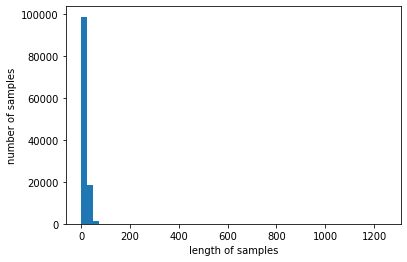

In [ ]:
print('train data의 최대 길이 :',max(len(l) for l in del_X_train))
print('train data의 평균 길이 :',sum(map(len, del_X_train))/len(del_X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

test data의 최대 길이 :  730
test data의 평균 길이 :  15.158524181952092


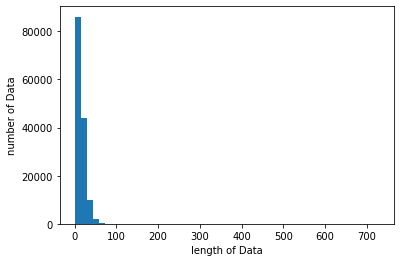

In [ ]:
print("test data의 최대 길이 : ", max(len(l) for l in token_X_test))
print("test data의 평균 길이 : ", sum(map(len, token_X_test))/ len(token_X_test))
plt.hist([len(s) for s in token_X_test], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 200
below_threshold_len(max_len, del_X_train)

전체 샘플 중 길이가 200 이하인 샘플의 비율: 99.98481794181899


In [ ]:
pad_X_train = pad_sequences(del_X_train, maxlen = max_len, padding = 'post')
pad_X_test = pad_sequences(token_X_test, maxlen = max_len, padding = 'post')

In [ ]:
X_tr = pad_X_train[:110000]
X_te = pad_X_train[110000:]
y_tr = del_y_train[:110000]
y_te = del_y_train[110000:]

In [ ]:
model1 = Sequential()
model1.add(Embedding(vocab_size,128, input_length=max_len))
model1.add(Dropout(.4))
model1.add(Conv1D(128, 7, activation = 'relu', padding = 'same', kernel_regularizer=l2(0.01)))
model1.add(GlobalMaxPooling1D())
model1.add(Dense(1, activation = 'sigmoid'))
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 128)          1644288   
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 128)          114816    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,759,233
Trainable params: 1,759,233
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(optimizer=RMSprop(lr = .0005), loss='binary_crossentropy', metrics=['acc'])
reLR = ReduceLROnPlateau(patience = 3, verbose=1, factor = .3)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
mc = ModelCheckpoint(filepath = '1125(1)_1.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True, restore_best_weights = True)

In [ ]:
history1 = model1.fit(X_tr, y_tr, epochs=7, batch_size= 64, shuffle = True, validation_split=0.1, verbose = 1, callbacks=[es, mc])

Epoch 1/7
1547/1547 [==============================] - ETA: 0s - loss: 0.2352 - acc: 0.9254
Epoch 00001: val_loss improved from inf to 0.08394, saving model to 1125(1)_1.h5
1547/1547 [==============================] - 21s 13ms/step - loss: 0.2352 - acc: 0.9254 - val_loss: 0.0839 - val_acc: 0.9749
Epoch 2/7
1545/1547 [============================>.] - ETA: 0s - loss: 0.1272 - acc: 0.9566
Epoch 00002: val_loss improved from 0.08394 to 0.05816, saving model to 1125(1)_1.h5
1547/1547 [==============================] - 21s 13ms/step - loss: 0.1273 - acc: 0.9566 - val_loss: 0.0582 - val_acc: 0.9865
Epoch 3/7
1544/1547 [============================>.] - ETA: 0s - loss: 0.1180 - acc: 0.9609
Epoch 00003: val_loss improved from 0.05816 to 0.05712, saving model to 1125(1)_1.h5
1547/1547 [==============================] - 20s 13ms/step - loss: 0.1180 - acc: 0.9609 - val_loss: 0.0571 - val_acc: 0.9833
Epoch 4/7
1543/1547 [============================>.] - ETA: 0s - loss: 0.1133 - acc: 0.9628
Epoch 

In [ ]:
model1 = load_model('1125(1)_1.h5')

In [ ]:
pred1 = model1.predict_classes(X_te)

In [ ]:
pred_list = []
for i in range(len(pred1)) :
  
  pred_list.append(pred1[i][0])

In [ ]:
accuracy_score(y_te, pred_list)

0.9892535918701086

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 128, input_length = max_len))
model2.add(SpatialDropout1D(0.3))
model2.add(Bidirectional(LSTM(64)))
model2.add(Dropout(0.5))
model2.add(Dense(64, kernel_regularizer = l2(0.001)))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 128)          1644288   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 200, 128)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 1,751,425
Trainable params: 1,751,425
Non-trainable params: 0
___________________________________________

In [ ]:
model2.compile(optimizer=RMSprop(lr = .0005), loss='binary_crossentropy', metrics=['acc'])
reLR = ReduceLROnPlateau(patience = 5, verbose=1, factor = .2)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience = 2)
mc = ModelCheckpoint(filepath = '1125(2)_1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True, restore_best_weights = True)

In [ ]:
history2 = model2.fit(X_tr, y_tr, epochs=10, batch_size= 32, shuffle = True, validation_split=0.1, verbose = 1, callbacks=[es, mc, reLR])

Epoch 1/10
3092/3094 [============================>.] - ETA: 0s - loss: 0.1487 - acc: 0.9442
Epoch 00001: val_acc improved from -inf to 0.97855, saving model to 1125(2)_1.h5
3094/3094 [==============================] - 75s 24ms/step - loss: 0.1486 - acc: 0.9442 - val_loss: 0.0488 - val_acc: 0.9785
Epoch 2/10
3093/3094 [============================>.] - ETA: 0s - loss: 0.0995 - acc: 0.9625
Epoch 00002: val_acc improved from 0.97855 to 0.98618, saving model to 1125(2)_1.h5
3094/3094 [==============================] - 75s 24ms/step - loss: 0.0995 - acc: 0.9625 - val_loss: 0.0330 - val_acc: 0.9862
Epoch 3/10
3093/3094 [============================>.] - ETA: 0s - loss: 0.0912 - acc: 0.9659
Epoch 00003: val_acc did not improve from 0.98618
3094/3094 [==============================] - 74s 24ms/step - loss: 0.0912 - acc: 0.9659 - val_loss: 0.0547 - val_acc: 0.9731
Epoch 4/10
3092/3094 [============================>.] - ETA: 0s - loss: 0.0824 - acc: 0.9696
Epoch 00004: val_acc did not improve f

In [ ]:
model2 = load_model('1125(2)_1.h5')

In [ ]:
pred2 = model2.predict_classes(X_te)

In [ ]:
pred_list = []
for i in range(len(pred2)) :
  
  pred_list.append(pred2[i][0])

In [ ]:
accuracy_score(y_te, pred_list)

0.9892535918701086

In [ ]:
pred1 = model1.predict_classes(pad_X_test)
pred2 = model2.predict_classes(pad_X_test)

In [ ]:
submission['info'] = (pred1 * pred2) ** .5

In [ ]:
submission.to_csv('1125_2.csv', index = False)